<a href="https://colab.research.google.com/github/ShivamSinghal1/Talkingdata-Dataset/blob/main/Talkingdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gc

In [ ]:
traincolumns = ['ip','app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8'
        }
path = '/content/drive/MyDrive/Dataset/train_sample.csv'
df = pd.read_csv(path, usecols = traincolumns, dtype=dtypes)

In [ ]:
df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [ ]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [ ]:
# Checking for null values if any 
df.isnull().values.any()

### Data Preparation 

Make some new features with click_time column 


In [ ]:
df["datetime"] = pd.to_datetime(df['click_time'])
df['dow']      = df['datetime'].dt.dayofweek.astype('uint8')
df['hour'] 	   = df['datetime'].dt.hour.astype('uint8')
df['minute']   = df['datetime'].dt.minute.astype('uint8')
df['second']   = df['datetime'].dt.second.astype('uint8')

df.head()

,ip,app,device,os,channel,click_time,is_attributed,datetime,dow,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017-11-07 09:30:38,1,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,0,2017-11-07 13:40:27,1,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017-11-07 18:05:24,1,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017-11-07 04:58:08,1,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017-11-09 09:00:09,3,9,0,9


In [ ]:
# We will drop click_time and datetime
df = df.drop(['click_time','datetime'],axis=1)
gc.collect()

75

In [ ]:
y = df['is_attributed']
X = df.drop(['is_attributed'], axis=1)
print(X.head()) 
print(y.head())

       ip  app  device  os  channel  dow  hour  minute  second
0   87540   12       1  13      497    1     9      30      38
1  105560   25       1  17      259    1    13      40      27
2  101424   12       1  19      212    1    18       5      24
3   94584   13       1  13      477    1     4      58       8
4   68413   12       1   1      178    3     9       0       9
0    0
1    0
2    0
3    0
4    0
Name: is_attributed, dtype: uint8


In [ ]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True, stratify=y,
                                                    test_size=0.2, random_state=2)

print(X_train.shape, X_test.shape ,  y_train.shape, y_test.shape)

y_train.mean()*100 , y_test.mean()*100

(80000, 9) (20000, 9) (80000,) (20000,)


(0.2275, 0.22499999999999998)

In [ ]:
# Plot confusion matrix 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (5,5)):
    sns.set(font_scale=1.5)
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(5,5))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 12)
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.tick_params(axis='both', labelsize=12)
    plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## XGBOOST

In [ ]:
params = {'eta': 0.1, # learning rate
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
}

In [ ]:
x_train, x_valid, Y_train, Y_valid = train_test_split(X_train, y_train,
                                                    shuffle=True, stratify=y_train,
                                                    test_size=0.25, random_state=2)
dtrain = xgb.DMatrix(x_train, Y_train)
dvalid = xgb.DMatrix(x_valid, Y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 1000, watchlist, maximize=True, early_stopping_rounds=50, verbose_eval=10)

[0]	train-auc:0.820479	valid-auc:0.824341
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.86618	valid-auc:0.858746
[20]	train-auc:0.925478	valid-auc:0.88582
[30]	train-auc:0.927089	valid-auc:0.885661
[40]	train-auc:0.966933	valid-auc:0.91689
[50]	train-auc:0.966506	valid-auc:0.919104
[60]	train-auc:0.990883	valid-auc:0.923884
[70]	train-auc:0.995824	valid-auc:0.904415
[80]	train-auc:0.997093	valid-auc:0.907906
[90]	train-auc:0.997956	valid-auc:0.910362
[100]	train-auc:0.99851	valid-auc:0.920127
Stopping. Best iteration:
[57]	train-auc:0.981001	valid-auc:0.941755



In [ ]:
# Model.predict
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest , output_margin=True)

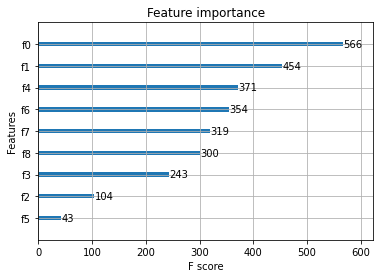

In [ ]:
xgb.plot_importance(model)

In [ ]:
xgb.to_graphviz(model)

In [ ]:
y_pred[y_pred >= 0] = 1
y_pred[y_pred < 0] = 0

In [ ]:
print(classification_report(y_test, y_pred, digits = 5))

              precision    recall  f1-score   support

           0    0.99820   0.99965   0.99892     19955
           1    0.56250   0.20000   0.29508        45

    accuracy                        0.99785     20000
   macro avg    0.78035   0.59982   0.64700     20000
weighted avg    0.99722   0.99785   0.99734     20000



## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB 

In [ ]:
clf = BernoulliNB()

In [ ]:
model = clf.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 20000 points : 70


In [ ]:
print(classification_report(y_test , y_pred , digits = 5))

              precision    recall  f1-score   support

           0    0.99790   0.99860   0.99825     19955
           1    0.09677   0.06667   0.07895        45

    accuracy                        0.99650     20000
   macro avg    0.54734   0.53263   0.53860     20000
weighted avg    0.99587   0.99650   0.99618     20000



## SVM

In [ ]:
# #Applying PCA to retain 95% variation and reduce features
from sklearn.decomposition import PCA
pca = PCA(n_components=.80)
pca.fit(X_train)
X_train_p = pca.transform(X_train)
X_test_p = pca.transform(X_test)
pca.explained_variance_ratio_*100
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_p = scaler.fit_transform(X_train_p.astype(np.float32))
X_test_p = scaler.transform(X_test_p.astype(np.float32))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
param_grid = {  
              'C': [1 ,10], 
          
              'gamma': [0.01 ,.1 ,1], 
              
              'kernel':['linear','rbf'],

              'decision_function_shape':['ovr','ovo','dag']
              
              }

          # , 0.001, 0.005, 0.01, 0.1
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = RandomizedSearchCV(SVC(), param_grid,verbose=10,cv=5 ,n_iter=1000 , scoring='roc_auc')
clf = clf.fit(X_train_p, y_train)


clf.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 36 is smaller than n_iter=1000. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1 .....
[CV]  kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1, score=0.742, total=   0.2s
[CV] kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1, score=0.386, total=   0.2s
[CV] kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1 .....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1, score=0.785, total=   0.2s
[CV] kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1 .....


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV]  kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1, score=0.377, total=   0.2s
[CV] kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1 .....


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


[CV]  kernel=linear, gamma=0.01, decision_function_shape=ovr, C=1, score=0.725, total=   0.2s
[CV] kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1 ........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s remaining:    0.0s


[CV]  kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1, score=0.683, total=   0.7s
[CV] kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1 ........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


[CV]  kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1, score=0.349, total=   0.7s
[CV] kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1 ........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.5s remaining:    0.0s


[CV]  kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1, score=0.581, total=   0.7s
[CV] kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1 ........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.3s remaining:    0.0s


[CV]  kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1, score=0.442, total=   0.7s
[CV] kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1 ........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.0s remaining:    0.0s


[CV]  kernel=rbf, gamma=0.01, decision_function_shape=ovr, C=1, score=0.313, total=   0.7s
[CV] kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1 ......
[CV]  kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1, score=0.742, total=   0.2s
[CV] kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1 ......
[CV]  kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1, score=0.386, total=   0.2s
[CV] kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1 ......
[CV]  kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1, score=0.785, total=   0.2s
[CV] kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1 ......
[CV]  kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1, score=0.377, total=   0.2s
[CV] kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1 ......
[CV]  kernel=linear, gamma=0.1, decision_function_shape=ovr, C=1, score=0.725, total=   0.2s
[CV] kernel=rbf, gamma=0.1, decision_function_shape=ovr, C=1 .........
[CV]  kernel=rbf, 

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  2.0min finished


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print(classification_report(y_test ,clf.predict(X_test_p) ,digits=5))

              precision    recall  f1-score   support

           0    0.99775   1.00000   0.99887     19955
           1    0.00000   0.00000   0.00000        45

    accuracy                        0.99775     20000
   macro avg    0.49888   0.50000   0.49944     20000
weighted avg    0.99551   0.99775   0.99663     20000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
clf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators': [1,5,50]
    
}, cv=StratifiedKFold(5), return_train_score=False)
clf.fit(X_train, y_train)
scores = []

scores.append({
    'best_score': clf.best_score_,
    'best_params': clf.best_params_
    })
    
did = pd.DataFrame(scores,columns=['best_score','best_params'])
did


,best_score,best_params
0,0.99775,{'n_estimators': 50}


In [ ]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test ,clf.predict(X_test) ,digits=5))

              precision    recall  f1-score   support

           0    0.99820   0.99995   0.99907     19955
           1    0.90000   0.20000   0.32727        45

    accuracy                        0.99815     20000
   macro avg    0.94910   0.59997   0.66317     20000
weighted avg    0.99798   0.99815   0.99756     20000

